### Problem statement: 
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path('Skin cancer ISIC/Train/')
data_dir_test = pathlib.Path('Skin cancer ISIC/Test/')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

# Create the train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir_train,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=32  
)


Found 2239 files belonging to 9 classes.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

# Create the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=data_dir_test,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=32  
)


Found 118 files belonging to 9 classes.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

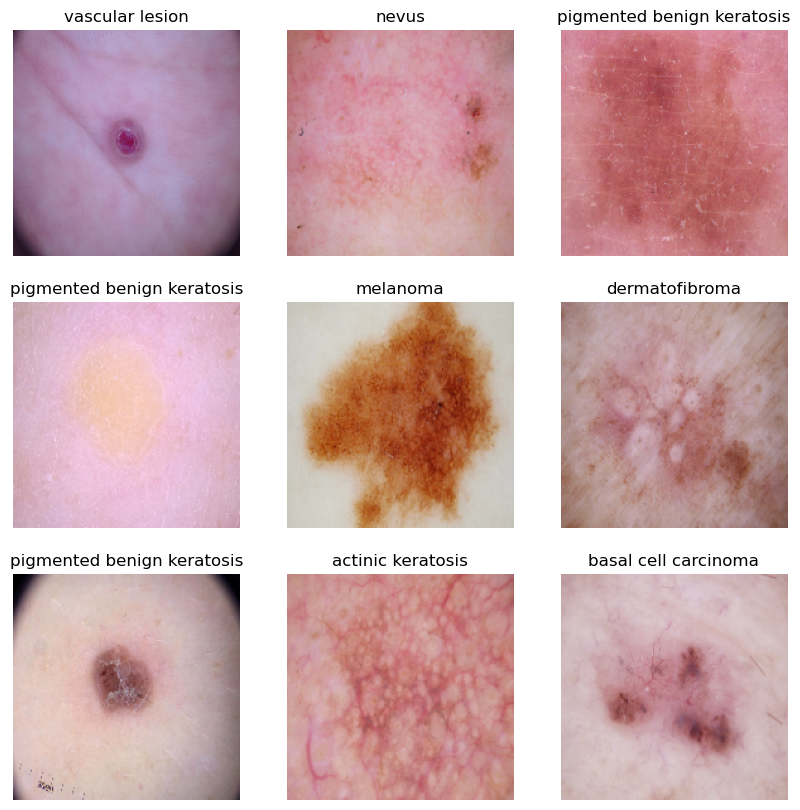

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Display the first 9 images from the batch
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers.experimental.preprocessing import Rescaling


# Define the model
model = Sequential([
    
    Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    # First convolutional layer
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(),

    # Second convolutional layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),

    # Third convolutional layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(),

    # Flatten the output of the convolutional layers
    Flatten(),

    # Dense layer with 128 units
    Dense(128, activation='relu'),

    # Output layer with 9 units (one for each class) with softmax activation
    Dense(9, activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Train the model

In [14]:

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


70/70 [==============================] - 50s 623ms/step - loss: 2.0084 - accuracy: 0.2519 - val_loss: 2.1598 - val_accuracy: 0.3051
Epoch 2/20
70/70 [==============================] - 46s 659ms/step - loss: 1.5818 - accuracy: 0.4372 - val_loss: 2.0390 - val_accuracy: 0.3475
Epoch 3/20
70/70 [==============================] - 37s 527ms/step - loss: 1.3978 - accuracy: 0.5167 - val_loss: 2.3264 - val_accuracy: 0.3729
Epoch 4/20
70/70 [==============================] - 36s 515ms/step - loss: 1.3457 - accuracy: 0.5266 - val_loss: 2.3972 - val_accuracy: 0.3136
Epoch 5/20
70/70 [==============================] - 36s 521ms/step - loss: 1.2898 - accuracy: 0.5404 - val_loss: 2.7185 - val_accuracy: 0.3644
Epoch 6/20
70/70 [==============================] - 36s 516ms/step - loss: 1.2053 - accuracy: 0.5659 - val_loss: 2.2632 - val_accuracy: 0.3136
Epoch 7/20
70/70 [==============================] - 43s 616ms/step - loss: 1.2028 - accuracy: 0.5659 - val_loss: 2.5416 - val_accuracy: 0.37

### Visualizing training results

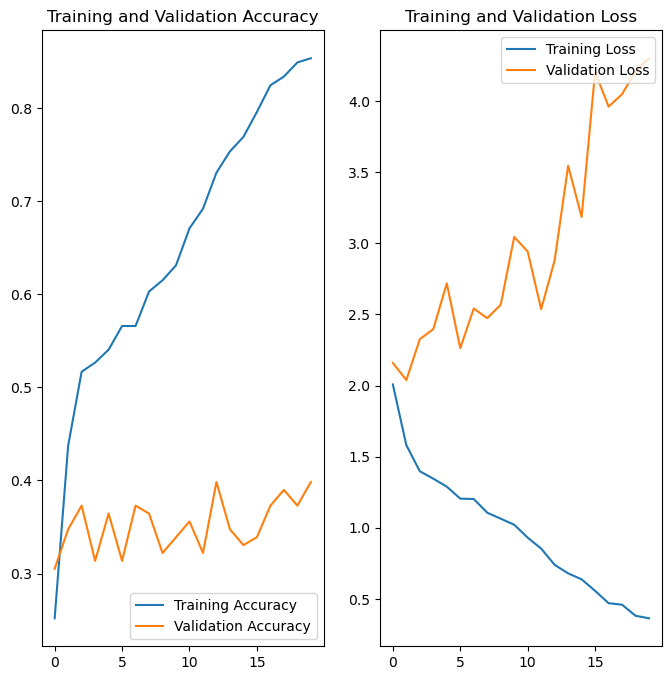

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

1. Training accuracy increases consistently throughout the training process, which suggests the model is learning and improving its performance on the training data.

2. Validation accuracy is much lower than the training accuracy and does not show a similar improvement. It remains fairly flat, indicating that the model is not generalizing well to new data and is a sign of overfitting.

3. Training loss decreases steadily, which is typical during the training of a model as it learns from the training data.

4. Validation loss initially decreases but then starts to increase again, diverging from the training loss. This is a classic indication of overfitting; the model performs increasingly well on the training data but fails to achieve comparable results on the validation data.

### Write your findings here

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)


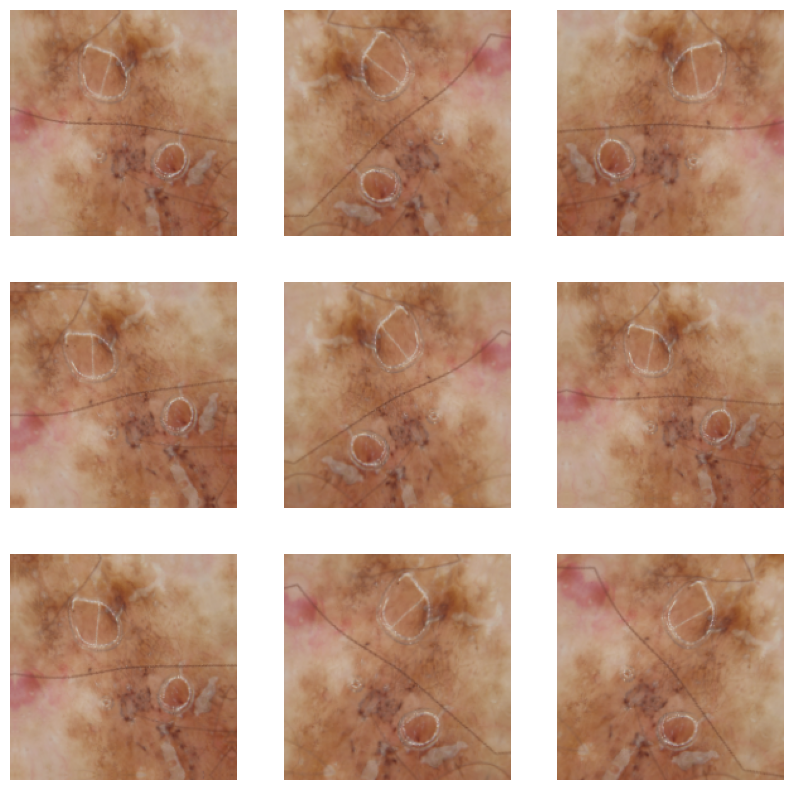

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [18]:
# Check the shape of dataset elements
print(train_ds.element_spec)
print(val_ds.element_spec)

(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


### Todo:
### Create the model, compile and train the model


In [19]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization


## You can use Dropout layer if there is an evidence of overfitting in your findings
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
model = Sequential([
    
        data_augmentation,
        Rescaling(1./255, input_shape=(img_height, img_width, 3)),
        Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(img_height, img_width, 3), kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),
        
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),
    
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),
    
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(9, activation='softmax')
    ])




In [20]:
    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 16)      448       
                                                                 
 batch_normalization (Batch  (None, 178, 178, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 89, 89, 16)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 89, 89, 16)       

In [21]:
# Train the model with data augmentation
#train_ds_augmented = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

## Your code goes here, note: train your model for 20 epochs


epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/20
70/70 [==============================] - 34s 446ms/step - loss: 4.0414 - accuracy: 0.2425 - val_loss: 27.3435 - val_accuracy: 0.1356
Epoch 2/20
70/70 [==============================] - 28s 401ms/step - loss: 2.4379 - accuracy: 0.2590 - val_loss: 22.3819 - val_accuracy: 0.1356
Epoch 3/20
70/70 [==============================] - 26s 365ms/step - loss: 2.3618 - accuracy: 0.3059 - val_loss: 12.8232 - val_accuracy: 0.1864
Epoch 4/20
70/70 [==============================] - 25s 364ms/step - loss: 2.2897 - accuracy: 0.3247 - val_loss: 4.9037 - val_accuracy: 0.1441
Epoch 5/20
70/70 [==============================] - 25s 362ms/step - loss: 2.2855 - accuracy: 0.3095 - val_loss: 2.9253 - val_accuracy: 0.1525
Epoch 6/20
70/70 [==============================] - 26s 365ms/step - loss: 2.3123 - accuracy: 0.3042 - val_loss: 5.0627 - val_accuracy: 0.2203
Epoch 7/20
70/70 [==============================] - 25s 361ms/step - loss: 2.2426 - accuracy: 0.3269 - val_loss: 4.1758 - val_accuracy: 0.1

### Visualizing the results

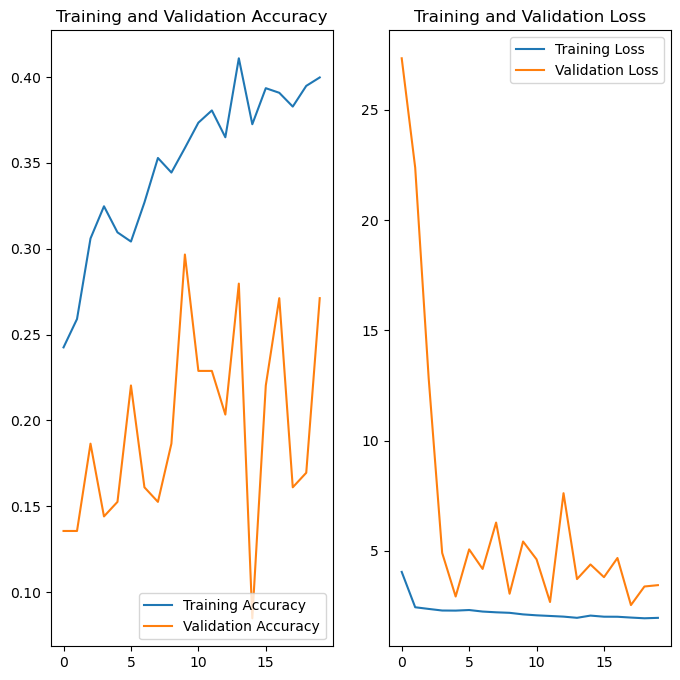

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

- The training accuracy is increasing over epochs, which is a good sign that the model is learning from the training data.
- However, the validation accuracy is quite volatile and generally lower than the training accuracy. This suggests that the model may not be generalizing well to unseen data, a sign of overfitting.
- The training loss is decreasing, which is expected during the training process.
- The validation loss, on the other hand, shows high variability with sudden spikes. This is not typical behavior, as we would expect the validation loss to decrease and stabilize.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [23]:
# Find the distribution of classes in the training dataset.

class_counts = {}

for images, class_names in train_ds:
    # Assuming labels are tensors, convert them to numpy arrays
    labels = class_names.numpy()
    for label in labels:
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1

# Now class_counts dictionary contains the distribution of classes
print(class_counts)

{8: 139, 3: 438, 0: 114, 4: 357, 1: 376, 5: 462, 7: 181, 6: 77, 2: 95}


In [24]:
# Get a list of class directories
class_dirs = [d for d in os.listdir(data_dir_train) if os.path.isdir(os.path.join(data_dir_train, d))]

# Initialize a dictionary to hold the count of each class
class_distribution = {class_dir: len(os.listdir(os.path.join(data_dir_train, class_dir)))
                      for class_dir in class_dirs}

# Print the class distribution
for class_dir, count in class_distribution.items():
    print(f'Class {class_dir}: {count} instances')

Class actinic keratosis: 114 instances
Class basal cell carcinoma: 376 instances
Class dermatofibroma: 95 instances
Class melanoma: 438 instances
Class nevus: 357 instances
Class pigmented benign keratosis: 462 instances
Class seborrheic keratosis: 77 instances
Class squamous cell carcinoma: 181 instances
Class vascular lesion: 139 instances


In [25]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [26]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,Skin cancer ISIC\Train\actinic keratosis\ISIC_...,actinic keratosis
1,Skin cancer ISIC\Train\actinic keratosis\ISIC_...,actinic keratosis
2,Skin cancer ISIC\Train\actinic keratosis\ISIC_...,actinic keratosis
3,Skin cancer ISIC\Train\actinic keratosis\ISIC_...,actinic keratosis
4,Skin cancer ISIC\Train\actinic keratosis\ISIC_...,actinic keratosis
...,...,...
2234,Skin cancer ISIC\Train\vascular lesion\ISIC_00...,vascular lesion
2235,Skin cancer ISIC\Train\vascular lesion\ISIC_00...,vascular lesion
2236,Skin cancer ISIC\Train\vascular lesion\ISIC_00...,vascular lesion
2237,Skin cancer ISIC\Train\vascular lesion\ISIC_00...,vascular lesion


Class=0, n=114 (5.092%)
Class=1, n=376 (16.793%)
Class=2, n=95 (4.243%)
Class=3, n=438 (19.562%)
Class=4, n=357 (15.945%)
Class=5, n=462 (20.634%)
Class=6, n=77 (3.439%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)


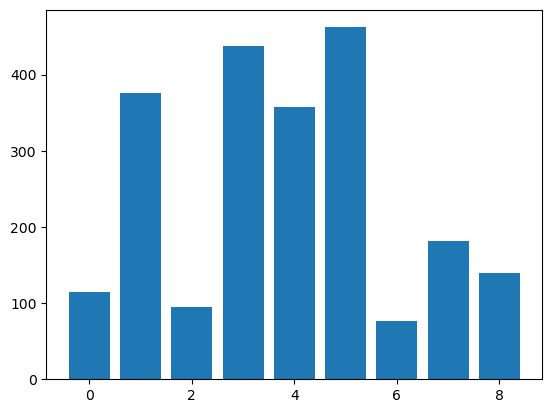

In [27]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

#### **Todo:** Write your findings here: 
- The class with the least number of samples is Class seborrheic keratosis, with only 77 instances.
- The classes that dominate the data in terms of proportionate number of samples are Class pigmented benign keratosis, with 462 instances, and Class melanoma, with 438 instances.

These classes have significantly more samples than the others, indicating a class imbalance that could potentially affect the performance of a machine learning model trained on this data. Addressing this imbalance, for instance by applying techniques such as oversampling the minority classes or undersampling the majority classes, would be an important step in preparing the data for model training.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [28]:
#!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [29]:
path_to_training_dataset="Skin cancer ISIC/Train/"
import os
import Augmentor
for class_dir in class_distribution.keys():
    class_name_str = str(class_dir) if not isinstance(class_dir, str) else class_dir
    print(path_to_training_dataset + class_name_str)
    print(class_distribution.keys())
    p = Augmentor.Pipeline(path_to_training_dataset + class_name_str)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.
    
    
#import Augmentor
#for i in class_names:
#    p = Augmentor.Pipeline(path_to_training_dataset + i)
#    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
#    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Skin cancer ISIC/Train/actinic keratosis
dict_keys(['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'])
Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x15066C8EED0>: 100%|█| 500/500 [00:08<00:00, 57.18 Samples/


Skin cancer ISIC/Train/basal cell carcinoma
dict_keys(['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'])
Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC/Train/basal cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1506724E850>: 100%|█| 500/500 [00:06<00:


Skin cancer ISIC/Train/dermatofibroma
dict_keys(['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'])
Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x15065A555D0>: 100%|█| 500/500 [00:06<00:00, 75.55 Samples/


Skin cancer ISIC/Train/melanoma
dict_keys(['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'])
Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC/Train/melanoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x15066EC7BD0>: 100%|█| 500/500 [00:33<00


Skin cancer ISIC/Train/nevus
dict_keys(['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'])
Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x1505EE24C90>: 100%|█| 500/500 [00:32<00:00, 15.32 Sample


Skin cancer ISIC/Train/pigmented benign keratosis
dict_keys(['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'])
Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1505F4A6350>: 100%|█| 500/500 [00:06<00:00, 77.65 Samples/


Skin cancer ISIC/Train/seborrheic keratosis
dict_keys(['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'])
Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1505F26A250>: 100%|█| 500/500 [00:15<00:00, 31.81 Samples


Skin cancer ISIC/Train/squamous cell carcinoma
dict_keys(['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'])
Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC/Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1505F4BCF90>: 100%|█| 500/500 [00:06<00:00, 82.45 Samples/


Skin cancer ISIC/Train/vascular lesion
dict_keys(['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'])
Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x15066CC6ED0>: 100%|█| 500/500 [00:06<00:00, 72.50 Samples/


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [30]:
#path_to_training_dataset="Skin cancer ISIC/Train/output/"

# Get a list of class directories
#class_dirs = [d for d in os.listdir(path_to_training_dataset) if os.path.isdir(os.path.join(path_to_training_dataset, d))]

# Initialize a dictionary to hold the count of each class
#class_distribution = {class_dir: len(os.listdir(os.path.join(path_to_training_dataset, class_dir)))
#                      for class_dir in class_dirs}

# Print the class distribution
#for class_dir, count in class_distribution.items():
#    print(f'Class {class_dir}: {count} instances')
    
    
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


# Lets see the distribution of augmented data after adding new images to the original training data.

In [31]:
import os
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Skin cancer ISIC\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_69d65fa5-37cf-4565-8aff-6979d9c4a547.jpg',
 'Skin cancer ISIC\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_b3ff5e7d-6157-4232-9f4a-af012221381a.jpg',
 'Skin cancer ISIC\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_f68dc7c9-a16f-4183-ab3d-7d4b4d2ebbf5.jpg',
 'Skin cancer ISIC\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_7e28d706-688e-41b4-99fd-7a254855bb2d.jpg',
 'Skin cancer ISIC\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_8bcfcd1f-d135-4542-84a5-d857631db005.jpg',
 'Skin cancer ISIC\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_ba75f643-0b18-481e-ae45-53effc4c68a1.jpg',
 'Skin cancer ISIC\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_cac7cc84-c949-4d4a-82b8-0daf88f82ff4.jpg',
 'Skin cancer

In [32]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [33]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [34]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)


In [35]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: count, dtype: int64

# So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [36]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [37]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [38]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [39]:
model = Sequential([
    
        data_augmentation,
        Rescaling(1./255, input_shape=(img_height, img_width, 3)),
        Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(img_height, img_width, 3), kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),
        
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),
    
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),
    
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(9, activation='softmax')
    ])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [40]:
    # Compile the model
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 178, 178, 16)      448       
                                                                 
 batch_normalization_3 (Bat  (None, 178, 178, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 89, 89, 16)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 89, 89, 16)       

#### **Todo:**  Train your model

In [41]:
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 84s 475ms/step - loss: 3.0508 - accuracy: 0.1823 - val_loss: 13.3570 - val_accuracy: 0.1128
Epoch 2/30
169/169 [==============================] - 73s 429ms/step - loss: 2.4619 - accuracy: 0.2020 - val_loss: 5.5181 - val_accuracy: 0.1180
Epoch 3/30
169/169 [==============================] - 73s 429ms/step - loss: 2.3825 - accuracy: 0.1927 - val_loss: 2.8458 - val_accuracy: 0.2502
Epoch 4/30
169/169 [==============================] - 73s 429ms/step - loss: 2.3439 - accuracy: 0.2081 - val_loss: 2.4334 - val_accuracy: 0.2279
Epoch 5/30
169/169 [==============================] - 73s 430ms/step - loss: 2.2834 - accuracy: 0.2148 - val_loss: 3.2268 - val_accuracy: 0.1500
Epoch 6/30
169/169 [==============================] - 82s 482ms/step - loss: 2.3294 - accuracy: 0.2003 - val_loss: 2.5817 - val_accuracy: 0.2480
Epoch 7/30
169/169 [==============================] - 74s 433ms/step - loss: 2.3366 - accuracy: 0.2051 - val_loss: 2.5216 - val_a

#### **Todo:**  Visualize the model results

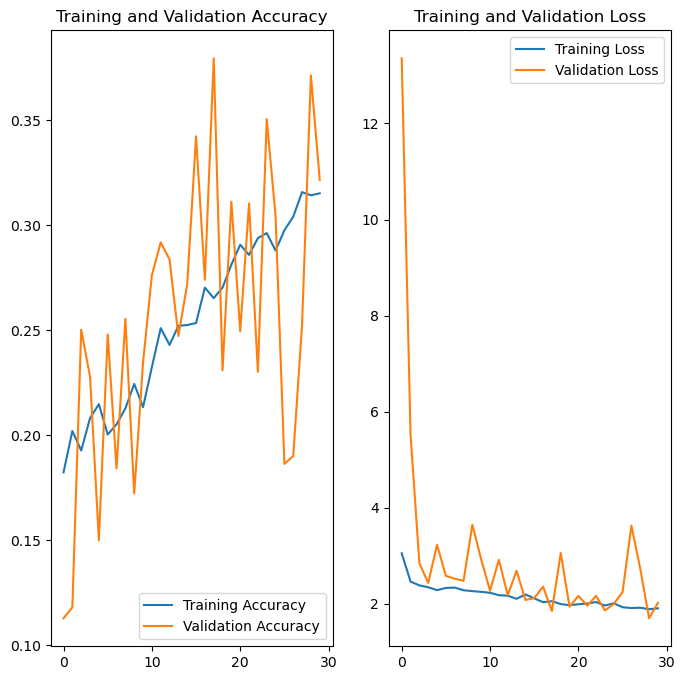

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



### Training and Validation Accuracy:

The training accuracy seems to be steadily increasing, which indicates the model is learning from the training data.
The validation accuracy is also increasing but is quite volatile and generally lower than the training accuracy. This suggests that while the model is learning, it may not be generalizing as well to new, unseen data.

### Training and Validation Loss:

The training loss is decreasing, which is expected as the model's predictions become more accurate on the training data.
The validation loss decreases as well but shows significant spikes at certain epochs. These spikes suggest that the model’s performance on the validation set is inconsistent.

### Analysis:

There's a gap between training and validation accuracy, with training accuracy being higher. This gap suggests a degree of overfitting because the model performs better on the training data than on the validation data. Overfitting happens when a model learns not only the underlying patterns but also the noise in the training dataset.
The volatility in the validation accuracy and the spikes in validation loss indicate that the model may not be stable across different sets of data.

It appears that overfitting is present, rather than underfitting. Underfitting would be indicated by poor performance on both training and validation data, which is not the case here.
